# **Homework #3_P3**

## **Problem 3: DANN (35%)** 
### **Task Definition**
In this problem, you need to implement DANN on digits datasets (USPS,
MNIST-M and SVHN) and consider the following 3 scenarios:   
(Source domain → Target domain)
USPS → MNIST-M, MNIST-M → SVHN, SVHN → USPS    
Note that during training DANN, we utilize the images and labels of source
domain, and only images (without labels) of target domain
### **Grading**
• If your accuracy of Problem 3-2 does not pass the baseline accuracy,
you only get 3 points in this sub-problem.    
*   Pass the baseline in one scenario: 3+3 points, two: 3+5 points, three: 3+7 points

• Baseline score for DANN:   
*   USPS → MNIST-M: 40% 
*   MNIST-M → SVHN: 40%
*   SVHN → USPS: 40%


• Your accuracy of problem 4-1 should surpass the accuracy reported in
problem 3-2. If not, you only get 6 points in this sub-problem.    
*   Improve in one scenario: 6+4 points, two: 6+7 points, three: 6+10 points

In [ ]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
path = 'drive/My Drive/senior_1/DLCV/HW/hw3'

Mounted at /content/drive


In [ ]:
!gdown --id '1Cz5eLSP7QRMkO0PqxZLldJ36nK6EWHR8' --output hw3_data.zip # 下載資料集
!unzip hw3_data.zip # 解壓縮
'''
1.  hw3_data/digits/mnistm/
      # num of data: 60,000 (training) / 10,000 (testing) # num of classes: 10 (0~9) # Image size: 28*28*3
      train/images.png
      test/images.png
      train.csv
      test.csv
2.  hw3_data/digits/svhn/
      # num of data: 73,257 (training) / 26,032 (testing) # num of classes: 10 (0~9) # Image size: 28*28*3
      train/images.png
      test/images.png
      train.csv
      test.csv
3.  hw3_data/digits/usps/
      # num of data: 7,291 (training) / 2,007 (testing) # num of classes: 10 (0~9) # Image size: 28*28*1
      train/images.png  
      test/images.png  
      train.csv
      test.csv
'''

In [ ]:
# set packages
!pip3 install certifi==2020.6.20
!pip3 install cycler==0.10.0
!pip3 install joblib==0.17.0
!pip3 install kiwisolver==1.2.0
!pip3 install matplotlib==3.3.2
!pip3 install numpy==1.18.1
!pip3 install pandas==1.1.3
!pip3 install Pillow==8.0.0
!pip3 install pyparsing==2.4.7
!pip3 install python-dateutil==2.8.1
!pip3 install pytz==2020.1
!pip3 install scikit-learn==0.21.3
!pip3 install scipy==1.2.1
!pip3 install six==1.15.0
!pip3 install torch==1.4.0
!pip3 install torchvision==0.5.0

In [ ]:
# Import 需要的套件
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import time
import pandas as pd
import random
import scipy.misc
import argparse
import imageio
from torch.autograd import Variable
from torch.optim import Adam, AdamW
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import manifold

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("torchvision.__version__ =", torchvision.__version__)
    print("torch.cuda.is_available() =", torch.cuda.is_available())

same_seeds(0)

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


#Read image

In [ ]:
def sortfile(path):
    index = []
    image_dir = sorted(os.listdir(path)) # 把圖檔按照編號排列
    for i, file in enumerate(image_dir):
        index.append([file, int(file.replace('.png', ''))])
    index = sorted(index, key = lambda s: s[1])
    return index

def readfile(path, index, mode):
    x = np.zeros((len(index), 28, 28, 3), dtype=np.uint8)
    y = np.zeros((len(index)), dtype=np.uint8)
    pd_y = pd.read_csv(os.path.join(path, mode + ".csv"))
    for i, file in enumerate(index):
        img = imageio.imread(os.path.join(os.path.join(path, mode), file[0]))
        if 'usps' in path:
            temp_x = img.reshape(28, 28, 1) # expand dim
            x[i, :, :] = np.concatenate((temp_x, temp_x, temp_x), axis = 2)
        else:
            x[i, :, :] = img 
        y[i] = pd_y['label'][i] 
    return x, y

In [ ]:
# 分別將 training set、testing set 用 sortfile, readfile 函式讀進來
workspace_dir = './hw3_data/digits'
digits_data_list = ['mnistm', 'svhn', 'usps']

for index in digits_data_list:
    print("Reading " + index + " data")
    split_ratio = 0.2
    train_index = sortfile(os.path.join(workspace_dir, os.path.join(index, "train")))
    test_index = sortfile(os.path.join(workspace_dir, os.path.join(index, "test")))
    if index == 'mnistm':
        mnistm_train_x, mnistm_train_y = readfile(os.path.join(workspace_dir, index), train_index, "train")
        # split train / val, ratio = split_ratio
        mnistm_train_x, mnistm_val_x, mnistm_train_y, mnistm_val_y = train_test_split(mnistm_train_x, mnistm_train_y, test_size = split_ratio, random_state = 3)
        mnistm_test_x, mnistm_test_y = readfile(os.path.join(workspace_dir, index), test_index, "test")
        mnistm_test_index = pd.DataFrame(test_index)[0].values.tolist()
    elif index == 'svhn':
        svhn_train_x, svhn_train_y = readfile(os.path.join(workspace_dir, index), train_index, "train")
        # split train / val, ratio = split_ratio
        svhn_train_x, svhn_val_x, svhn_train_y, svhn_val_y = train_test_split(svhn_train_x, svhn_train_y, test_size = split_ratio, random_state = 3) 
        svhn_test_x, svhn_test_y = readfile(os.path.join(workspace_dir, index), test_index, "test")
        svhn_test_index = pd.DataFrame(test_index)[0].values.tolist()  
    else:
        usps_train_x, usps_train_y = readfile(os.path.join(workspace_dir, index), train_index, "train")
        # split train / val, ratio = split_ratio
        usps_train_x,usps_val_x, usps_train_y, usps_val_y = train_test_split(usps_train_x, usps_train_y, test_size = split_ratio, random_state = 3)
        usps_test_x, usps_test_y = readfile(os.path.join(workspace_dir, index), test_index, "test") 
        usps_test_index = pd.DataFrame(test_index)[0].values.tolist()
    print("Size of {} training data = {}".format(index, round(len(train_index)*(1-split_ratio))))
    print("Size of {} validation data = {}".format(index, round(len(train_index)*split_ratio)))
    print("Size of {} testing data = {}".format(index, round(len(test_index))))

Reading mnistm data
Size of mnistm training data = 48000
Size of mnistm validation data = 12000
Size of mnistm testing data = 10000
Reading svhn data
Size of svhn training data = 58606
Size of svhn validation data = 14651
Size of svhn testing data = 26032
Reading usps data
Size of usps training data = 5833
Size of usps validation data = 1458
Size of usps testing data = 2007


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [ ]:
# training 時需做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(), # 轉成 python 圖片
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片，表示在（-15，+15）之間隨機旋轉，旋轉後空的地方補 0
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization) ps. Tensor 為多維張量
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # normalize
])

# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # normalize
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None): # transform 自己決定
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [ ]:
batch_size = 64
train_x_list = [mnistm_train_x, svhn_train_x, usps_train_x]
val_x_list = [mnistm_val_x, svhn_val_x, usps_val_x]
test_x_list = [mnistm_test_x, svhn_test_x, usps_test_x]
train_y_list = [mnistm_train_y, svhn_train_y, usps_train_y]
val_y_list = [mnistm_val_y, svhn_val_y, usps_val_y]
test_y_list = [mnistm_test_y, svhn_test_y, usps_test_y]
for i in range(len(train_x_list)):
    train_set = ImgDataset(train_x_list[i], train_y_list[i], transform=train_transform)
    val_set = ImgDataset(val_x_list[i], val_y_list[i], transform=test_transform)
    test_set = ImgDataset(test_x_list[i], test_y_list[i], transform=test_transform)
    if i == 0: # mnistm
        mnistm_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        mnistm_val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
        mnistm_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
        print('finish mnistm_loader')
    elif i == 1: # svhn
        svhn_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        svhn_val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
        svhn_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
        print('finish svhn_loader')
    else: # usps
        usps_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        usps_val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
        usps_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
        print('finish usps_loader')

finish mnistm_loader
finish svhn_loader
finish usps_loader


# Training

## USPS → MNIST-M

### Trained on source

model

In [ ]:
class USPS2MNISTM_SourceClassifier(nn.Module):

    def __init__(self):
        super(USPS2MNISTM_SourceClassifier, self).__init__()

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]      
        )   
        
        self.linear = nn.Sequential(
            # flatten
            nn.Linear(in_features=512*2*2, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=512, out_features=10, bias=True),
        )       

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        out = self.linear(x)
        return x

training

In [ ]:
USPS2MNISTM_source_model = USPS2MNISTM_SourceClassifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(USPS2MNISTM_source_model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 100
best_val_acc = 0.0

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    source_train_acc = 0.0
    source_train_loss = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    target_test_acc = 0.0
    target_test_loss = 0.0

    USPS2MNISTM_source_model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(usps_train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        source_train_pred = USPS2MNISTM_source_model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        source_batch_loss = loss(source_train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        source_batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        source_train_acc += np.sum(np.argmax(source_train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        source_train_loss += source_batch_loss.item()
    
    USPS2MNISTM_source_model.eval()
    with torch.no_grad():
        for i, data in enumerate(mnistm_val_loader):
            target_val_pred = USPS2MNISTM_source_model(data[0].cuda())
            target_batch_loss = loss(target_val_pred, data[1].cuda())

            target_val_acc += np.sum(np.argmax(target_val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_val_loss += target_batch_loss.item()

        for i, data in enumerate(mnistm_test_loader):
            target_test_pred = USPS2MNISTM_source_model(data[0].cuda())
            target_batch_loss = loss(target_test_pred, data[1].cuda())

            target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_test_loss += target_batch_loss.item()

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(USPS2MNISTM_source_model.state_dict(), os.path.join(path, 'p3_USPS2MNISTM_source_model.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-epoch_start_time))
    print('source train acc: {:.4f}, source train loss: {:.5f}, target val acc: {:.4f}, target val loss: {:.5f}'.format(
        source_train_acc/len(usps_train_x), source_train_loss/len(usps_train_x), target_val_acc/len(mnistm_val_x), target_val_loss/len(mnistm_val_x)
    ))
    print('target test acc: {:.4f}, target test loss: {:.5f}'.format(
        target_test_acc/len(mnistm_test_x), target_test_loss/len(mnistm_test_x)
    ))  

In [ ]:
USPS2MNISTM_source_model = USPS2MNISTM_SourceClassifier().cuda()
USPS2MNISTM_source_model.load_state_dict(torch.load(os.path.join(path, 'p3_USPS2MNISTM_source_model.pkl')))
target_test_acc = 0.0
target_test_loss = 0.0
USPS2MNISTM_source_model.eval()
with torch.no_grad():
    for i, data in enumerate(mnistm_test_loader):
        target_test_pred = USPS2MNISTM_source_model(data[0].cuda())
        target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
    print('target test acc: {:.4f}'.format(
        target_test_acc/len(mnistm_test_x)
    ))  

target test acc: 0.2803


### Adaptation (DANN)

model

In [ ]:
class USPS2MNISTM_DANN_FeatureExtractor(nn.Module):

    def __init__(self):
        super(USPS2MNISTM_DANN_FeatureExtractor, self).__init__()  

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 1, 1]        
        )           

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        return x

class USPS2MNISTM_DANN_LabelPredictor(nn.Module):

    def __init__(self):
        super(USPS2MNISTM_DANN_LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class USPS2MNISTM_DANN_DomainClassifier(nn.Module):

    def __init__(self):
        super(USPS2MNISTM_DANN_DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

training

In [ ]:
# set model
USPS2MNISTM_DANN_feature_extractor = USPS2MNISTM_DANN_FeatureExtractor().cuda()
USPS2MNISTM_DANN_label_predictor = USPS2MNISTM_DANN_LabelPredictor().cuda()
USPS2MNISTM_DANN_domain_classifier = USPS2MNISTM_DANN_DomainClassifier().cuda()

# set loss function
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

# set optimizer
optimizer_F = torch.optim.Adam(USPS2MNISTM_DANN_feature_extractor.parameters())
optimizer_C = torch.optim.Adam(USPS2MNISTM_DANN_label_predictor.parameters())
optimizer_D = torch.optim.Adam(USPS2MNISTM_DANN_domain_classifier.parameters())

num_epoch = 100
best_val_acc = 0.0
lamb = 0.1

for epoch in range(num_epoch):
    training_epoch_time = time.time()
    running_D_loss = 0.0
    running_F_loss = 0.0
    source_train_acc = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    source_num = 0.0
    target_val_num = 0.0

    USPS2MNISTM_DANN_feature_extractor.train()
    USPS2MNISTM_DANN_label_predictor.train()
    USPS2MNISTM_DANN_domain_classifier.train()
    for i, ((source_data, source_label), (target_train_data, _)) in enumerate(zip(usps_train_loader, mnistm_train_loader)):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_train_data = target_train_data.cuda()
        
        # 我們把source data和target data混在一起，否則batch_norm可能會算錯 (兩邊的data的mean/var不太一樣)
        mixed_data = torch.cat([source_data, target_train_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_train_data.shape[0], 1]).cuda()
        # 設定source data的label為1
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : 訓練 Domain Classifier
        feature = USPS2MNISTM_DANN_feature_extractor(mixed_data)
        # 因為我們在 Step 1 不需要訓練 Feature Extractor，所以把 feature detach 避免loss backprop 上去。
        domain_logits = USPS2MNISTM_DANN_domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : 訓練 Feature Extractor 和 Domain Classifier
        class_logits = USPS2MNISTM_DANN_label_predictor(feature[:source_data.shape[0]])
        domain_logits = USPS2MNISTM_DANN_domain_classifier(feature)
        # loss 為原本的 class CE - lamb * domain BCE，相減的原因同 GAN 中的 Discriminator 中的 G loss。
        loss = class_criterion(class_logits, source_label) - lamb*domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        source_train_acc += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        source_num += source_data.shape[0]

    train_D_loss = running_D_loss / (i+1)
    train_F_loss = running_F_loss / (i+1)

    # Step 3 : test Domain Classifier on validation data
    USPS2MNISTM_DANN_feature_extractor.eval()
    USPS2MNISTM_DANN_label_predictor.eval()
    with torch.no_grad():
        for i, (target_val_data, target_val_label) in enumerate(mnistm_val_loader):
            target_val_data = target_val_data.cuda()
            target_val_label = target_val_label.cuda()
            feature = USPS2MNISTM_DANN_feature_extractor(target_val_data)
            class_logits = USPS2MNISTM_DANN_label_predictor(feature)
            target_val_acc += torch.sum(torch.argmax(class_logits, dim=1) == target_val_label).item()
            target_val_num += target_val_data.shape[0]

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(USPS2MNISTM_DANN_feature_extractor.state_dict(), os.path.join(path, 'p3_USPS2MNISTM_DANN_feature_extractor.pkl'))
        torch.save(USPS2MNISTM_DANN_label_predictor.state_dict(), os.path.join(path, 'p3_USPS2MNISTM_DANN_label_predictor.pkl'))
        torch.save(USPS2MNISTM_DANN_domain_classifier.state_dict(), os.path.join(path, 'p3_USPS2MNISTM_DANN_domain_classifier.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-training_epoch_time))
    print('source train acc: {:.4f}, source train D loss: {:.5f}, source train F loss: {:.5f}'.format(
        source_train_acc/source_num, train_D_loss, train_F_loss
    ))
    print('target val acc: {:.4f}, best val acc: {:.4f}'.format(
        target_val_acc/target_val_num, best_val_acc/target_val_num
    ))

testing

In [ ]:
USPS2MNISTM_DANN_feature_extractor = USPS2MNISTM_DANN_FeatureExtractor().cuda()
USPS2MNISTM_DANN_label_predictor = USPS2MNISTM_DANN_LabelPredictor().cuda()
USPS2MNISTM_DANN_feature_extractor.load_state_dict(torch.load(os.path.join(path, 'p3_USPS2MNISTM_DANN_feature_extractor.pkl')))
USPS2MNISTM_DANN_label_predictor.load_state_dict(torch.load(os.path.join(path, 'p3_USPS2MNISTM_DANN_label_predictor.pkl')))
USPS2MNISTM_DANN_feature_extractor.eval()
USPS2MNISTM_DANN_label_predictor.eval()
target_test_acc = 0.0
target_test_num = 0.0

with torch.no_grad():
    for i, (target_test_data, target_test_label) in enumerate(mnistm_test_loader):
        # Step 4 : test Domain Classifier on testing data
        target_test_data = target_test_data.cuda()
        target_test_label = target_test_label.cuda()
        feature = USPS2MNISTM_DANN_feature_extractor(target_test_data)
        class_logits = USPS2MNISTM_DANN_label_predictor(feature)
        target_test_acc += torch.sum(torch.argmax(class_logits, dim=1) == target_test_label).item()
        target_test_num += target_test_data.shape[0]

print('target test acc: {:.4f}'.format(target_test_acc/target_test_num))

target test acc: 0.6397


### Trained on target

model

In [ ]:
class USPS2MNISTM_TargetClassifier(nn.Module):

    def __init__(self):
        super(USPS2MNISTM_TargetClassifier, self).__init__()

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]      
        )   
        
        self.linear = nn.Sequential(
            # flatten
            nn.Linear(in_features=512*2*2, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=512, out_features=10, bias=True),
        )       

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        out = self.linear(x)
        return x

training

In [ ]:
USPS2MNISTM_target_model = USPS2MNISTM_TargetClassifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(USPS2MNISTM_target_model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 40
best_val_acc = 0.0

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    target_train_acc = 0.0
    target_train_loss = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    target_test_acc = 0.0
    target_test_loss = 0.0

    USPS2MNISTM_target_model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(mnistm_train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        target_train_pred = USPS2MNISTM_target_model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        target_batch_loss = loss(target_train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        target_batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        target_train_acc += np.sum(np.argmax(target_train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        target_train_loss += target_batch_loss.item()
    
    USPS2MNISTM_target_model.eval()
    with torch.no_grad():
        for i, data in enumerate(mnistm_val_loader):
            target_val_pred = USPS2MNISTM_target_model(data[0].cuda())
            target_batch_loss = loss(target_val_pred, data[1].cuda())

            target_val_acc += np.sum(np.argmax(target_val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_val_loss += target_batch_loss.item()

        for i, data in enumerate(mnistm_test_loader):
            target_test_pred = USPS2MNISTM_target_model(data[0].cuda())
            target_batch_loss = loss(target_test_pred, data[1].cuda())

            target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_test_loss += target_batch_loss.item()

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(USPS2MNISTM_target_model.state_dict(), os.path.join(path, 'p3_USPS2MNISTM_target_model.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-epoch_start_time))
    print('target train acc: {:.4f}, target train loss: {:.5f}, target val acc: {:.4f}, target val loss: {:.5f}'.format(
        target_train_acc/len(mnistm_train_x), target_train_loss/len(mnistm_train_x), target_val_acc/len(mnistm_val_x), target_val_loss/len(mnistm_val_x)
    ))
    print('target test acc: {:.4f}, target test loss: {:.5f}'.format(
        target_test_acc/len(mnistm_test_x), target_test_loss/len(mnistm_test_x)
    ))  
# print('best_val_acc =', best_val_acc/len(mnistm_val_x))   

## MNIST-M → SVHN

### Trained on source

model

In [ ]:
class MNISTM2SVHN_SourceClassifier(nn.Module):

    def __init__(self):
        super(MNISTM2SVHN_SourceClassifier, self).__init__()

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]      
        )   
        
        self.linear = nn.Sequential(
            # flatten
            nn.Linear(in_features=512*2*2, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=512, out_features=10, bias=True),
        )       

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        out = self.linear(x)
        return x

training

In [ ]:
MNISTM2SVHN_source_model = MNISTM2SVHN_SourceClassifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(MNISTM2SVHN_source_model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 100
best_val_acc = 0.0

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    source_train_acc = 0.0
    source_train_loss = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    target_test_acc = 0.0
    target_test_loss = 0.0

    MNISTM2SVHN_source_model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(mnistm_train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        source_train_pred = MNISTM2SVHN_source_model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        source_batch_loss = loss(source_train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        source_batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        source_train_acc += np.sum(np.argmax(source_train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        source_train_loss += source_batch_loss.item()
    
    MNISTM2SVHN_source_model.eval()
    with torch.no_grad():
        for i, data in enumerate(svhn_val_loader):
            target_val_pred = MNISTM2SVHN_source_model(data[0].cuda())
            target_batch_loss = loss(target_val_pred, data[1].cuda())

            target_val_acc += np.sum(np.argmax(target_val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_val_loss += target_batch_loss.item()

        for i, data in enumerate(svhn_test_loader):
            target_test_pred = MNISTM2SVHN_source_model(data[0].cuda())
            target_batch_loss = loss(target_test_pred, data[1].cuda())

            target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_test_loss += target_batch_loss.item()

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(MNISTM2SVHN_source_model.state_dict(), os.path.join(path, 'p3_MNISTM2SVHN_source_model.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-epoch_start_time))
    print('source train acc: {:.4f}, source train loss: {:.5f}, target val acc: {:.4f}, target val loss: {:.5f}'.format(
        source_train_acc/len(mnistm_train_x), source_train_loss/len(mnistm_train_x), target_val_acc/len(svhn_val_x), target_val_loss/len(svhn_val_x)
    ))
    print('target test acc: {:.4f}, target test loss: {:.5f}'.format(
        target_test_acc/len(svhn_test_x), target_test_loss/len(svhn_test_x)
    ))    

In [ ]:
MNISTM2SVHN_source_model = MNISTM2SVHN_SourceClassifier().cuda()
MNISTM2SVHN_source_model.load_state_dict(torch.load(os.path.join(path, 'p3_MNISTM2SVHN_source_model.pkl')))
target_test_acc = 0.0
target_test_loss = 0.0
MNISTM2SVHN_source_model.eval()
with torch.no_grad():
    for i, data in enumerate(svhn_test_loader):
        target_test_pred = MNISTM2SVHN_source_model(data[0].cuda())
        target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
    print('target test acc: {:.4f}'.format(
        target_test_acc/len(svhn_test_x)
    ))  

target test acc: 0.2412


### Adaptation (DANN)

model

In [ ]:
class MNISTM2SVHN_DANN_FeatureExtractor(nn.Module):

    def __init__(self):
        super(MNISTM2SVHN_DANN_FeatureExtractor, self).__init__()  

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            # nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.BatchNorm2d(512),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),
            # # [batch_size, 512, 1, 1]        
        )           

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        return x

class MNISTM2SVHN_DANN_LabelPredictor(nn.Module):

    def __init__(self):
        super(MNISTM2SVHN_DANN_LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            # nn.Linear(512, 512),
            nn.Linear(512*2*2, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class MNISTM2SVHN_DANN_DomainClassifier(nn.Module):

    def __init__(self):
        super(MNISTM2SVHN_DANN_DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512*2*2, 512),
            # nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

training

In [ ]:
# set model
MNISTM2SVHN_DANN_feature_extractor = MNISTM2SVHN_DANN_FeatureExtractor().cuda()
MNISTM2SVHN_DANN_label_predictor = MNISTM2SVHN_DANN_LabelPredictor().cuda()
MNISTM2SVHN_DANN_domain_classifier = MNISTM2SVHN_DANN_DomainClassifier().cuda()

# set loss function
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

# set optimizer
optimizer_F = torch.optim.Adam(MNISTM2SVHN_DANN_feature_extractor.parameters())
optimizer_C = torch.optim.Adam(MNISTM2SVHN_DANN_label_predictor.parameters())
optimizer_D = torch.optim.Adam(MNISTM2SVHN_DANN_domain_classifier.parameters())

num_epoch = 100
best_val_acc = 0.0
lamb = 0.2

for epoch in range(num_epoch):
    training_epoch_time = time.time()
    running_D_loss = 0.0
    running_F_loss = 0.0
    source_train_acc = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    source_num = 0.0
    target_val_num = 0.0

    MNISTM2SVHN_DANN_feature_extractor.train()
    MNISTM2SVHN_DANN_label_predictor.train()
    for i, ((source_data, source_label), (target_train_data, _)) in enumerate(zip(mnistm_train_loader, svhn_train_loader)):
        MNISTM2SVHN_DANN_domain_classifier.train()
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_train_data = target_train_data.cuda()
        
        # 我們把source data和target data混在一起，否則batch_norm可能會算錯 (兩邊的data的mean/var不太一樣)
        mixed_data = torch.cat([source_data, target_train_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_train_data.shape[0], 1]).cuda()
        # 設定source data的label為1
        domain_label[:source_data.shape[0]] = 1 # source label = 1
        
        # Step 1 : 訓練Domain Classifier
        feature = MNISTM2SVHN_DANN_feature_extractor(mixed_data)
        # 因為我們在 Step 1 不需要訓練 Feature Extractor，所以把 feature detach 避免loss backprop 上去。
        domain_logits = MNISTM2SVHN_DANN_domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()
        
        # Step 2 : 訓練 Feature Extractor 和 Domain Classifier
        class_logits = MNISTM2SVHN_DANN_label_predictor(feature[:source_data.shape[0]])
        domain_logits = MNISTM2SVHN_DANN_domain_classifier(feature)
        # loss 為原本的 class CE - lamb * domain BCE，相減的原因同 GAN 中的 Discriminator 中的 G loss。
        loss = class_criterion(class_logits, source_label) - lamb*domain_criterion(domain_logits, domain_label) 
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        source_train_acc += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        source_num += source_data.shape[0]

    train_D_loss = running_D_loss / (i+1)
    train_F_loss = running_F_loss / (i+1)

    # Step 3 : test Domain Classifier on validation data
    MNISTM2SVHN_DANN_feature_extractor.eval()
    MNISTM2SVHN_DANN_label_predictor.eval()
    with torch.no_grad():
        for i, (target_val_data, target_val_label) in enumerate(svhn_val_loader):
            target_val_data = target_val_data.cuda()
            target_val_label = target_val_label.cuda()
            feature = MNISTM2SVHN_DANN_feature_extractor(target_val_data)
            class_logits = MNISTM2SVHN_DANN_label_predictor(feature)
            target_val_acc += torch.sum(torch.argmax(class_logits, dim=1) == target_val_label).item()
            target_val_num += target_val_data.shape[0]

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(MNISTM2SVHN_DANN_feature_extractor.state_dict(), os.path.join(path, 'p3_MNISTM2SVHN_DANN_feature_extractor.pkl'))
        torch.save(MNISTM2SVHN_DANN_label_predictor.state_dict(), os.path.join(path, 'p3_MNISTM2SVHN_DANN_label_predictor.pkl'))
        torch.save(MNISTM2SVHN_DANN_domain_classifier.state_dict(), os.path.join(path, 'p3_MNISTM2SVHN_DANN_domain_classifier.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-training_epoch_time))
    print('source train acc: {:.4f}, source train D loss: {:.5f}, source train F loss: {:.5f}'.format(
        source_train_acc/source_num, train_D_loss, train_F_loss
    ))
    print('target val acc: {:.4f}, best val acc: {:.4f}'.format(
        target_val_acc/target_val_num, best_val_acc/target_val_num
    ))

testing

In [ ]:
MNISTM2SVHN_DANN_feature_extractor = MNISTM2SVHN_DANN_FeatureExtractor().cuda()
MNISTM2SVHN_DANN_label_predictor = MNISTM2SVHN_DANN_LabelPredictor().cuda()
MNISTM2SVHN_DANN_feature_extractor.load_state_dict(torch.load(os.path.join(path, 'p3_MNISTM2SVHN_DANN_feature_extractor.pkl')))
MNISTM2SVHN_DANN_label_predictor.load_state_dict(torch.load(os.path.join(path, 'p3_MNISTM2SVHN_DANN_label_predictor.pkl')))
MNISTM2SVHN_DANN_feature_extractor.eval()
MNISTM2SVHN_DANN_label_predictor.eval()

target_test_acc = 0.0
target_test_num = 0.0
with torch.no_grad():
    for i, (target_test_data, target_test_label) in enumerate(svhn_test_loader):
        # Step 4 : test Domain Classifier on testing data
        target_test_data = target_test_data.cuda()
        target_test_label = target_test_label.cuda()
        feature = MNISTM2SVHN_DANN_feature_extractor(target_test_data)
        class_logits = MNISTM2SVHN_DANN_label_predictor(feature)
        target_test_acc += torch.sum(torch.argmax(class_logits, dim=1) == target_test_label).item()
        target_test_num += target_test_data.shape[0]

print('target test acc: {:.4f}'.format(target_test_acc/target_test_num))

target test acc: 0.4324


### Trained on target

model

In [ ]:
class MNISTM2SVHN_TargetClassifier(nn.Module):

    def __init__(self):
        super(MNISTM2SVHN_TargetClassifier, self).__init__()

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]      
        )   
        
        self.linear = nn.Sequential(
            # flatten
            nn.Linear(in_features=512*2*2, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=512, out_features=10, bias=True),
        )       

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        out = self.linear(x)
        return x

training

In [ ]:
MNISTM2SVHN_target_model = MNISTM2SVHN_TargetClassifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(MNISTM2SVHN_target_model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 100
best_val_acc = 0.0

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    target_train_acc = 0.0
    target_train_loss = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    target_test_acc = 0.0
    target_test_loss = 0.0

    MNISTM2SVHN_target_model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(svhn_train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        target_train_pred = MNISTM2SVHN_target_model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        target_batch_loss = loss(target_train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        target_batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        target_train_acc += np.sum(np.argmax(target_train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        target_train_loss += target_batch_loss.item()
    
    MNISTM2SVHN_target_model.eval()
    with torch.no_grad():
        for i, data in enumerate(svhn_val_loader):
            target_val_pred = MNISTM2SVHN_target_model(data[0].cuda())
            target_batch_loss = loss(target_val_pred, data[1].cuda())

            target_val_acc += np.sum(np.argmax(target_val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_val_loss += target_batch_loss.item()

        for i, data in enumerate(svhn_test_loader):
            target_test_pred = MNISTM2SVHN_target_model(data[0].cuda())
            target_batch_loss = loss(target_test_pred, data[1].cuda())

            target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_test_loss += target_batch_loss.item()

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(MNISTM2SVHN_target_model.state_dict(), os.path.join(path, 'p3_MNISTM2SVHN_target_model.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-epoch_start_time))
    print('target train acc: {:.4f}, target train loss: {:.5f}, target val acc: {:.4f}, target val loss: {:.5f}'.format(
        target_train_acc/len(svhn_train_x), target_train_loss/len(svhn_train_x), target_val_acc/len(svhn_val_x), target_val_loss/len(svhn_val_x)
    ))
    print('target test acc: {:.4f}, target test loss: {:.5f}'.format(
        target_test_acc/len(svhn_test_x), target_test_loss/len(svhn_test_x)
    ))    

# SVHN → USPS

### Train on source

model

In [ ]:
class SVHN2USPS_SourceClassifier(nn.Module):

    def __init__(self):
        super(SVHN2USPS_SourceClassifier, self).__init__()

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]      
        )   
        
        self.linear = nn.Sequential(
            # flatten
            nn.Linear(in_features=512*2*2, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=512, out_features=10, bias=True),
        )       

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        out = self.linear(x)
        return x

training

In [ ]:
SVHN2USPS_source_model = SVHN2USPS_SourceClassifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(SVHN2USPS_source_model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 100
best_val_acc = 0.0

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    source_train_acc = 0.0
    source_train_loss = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    target_test_acc = 0.0
    target_test_loss = 0.0

    SVHN2USPS_source_model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(svhn_train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        source_train_pred = SVHN2USPS_source_model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        source_batch_loss = loss(source_train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        source_batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        source_train_acc += np.sum(np.argmax(source_train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        source_train_loss += source_batch_loss.item()
    
    SVHN2USPS_source_model.eval()
    with torch.no_grad():
        for i, data in enumerate(usps_val_loader):
            target_val_pred = SVHN2USPS_source_model(data[0].cuda())
            target_batch_loss = loss(target_val_pred, data[1].cuda())

            target_val_acc += np.sum(np.argmax(target_val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_val_loss += target_batch_loss.item()

        for i, data in enumerate(usps_test_loader):
            target_test_pred = SVHN2USPS_source_model(data[0].cuda())
            target_batch_loss = loss(target_test_pred, data[1].cuda())

            target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_test_loss += target_batch_loss.item()

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(SVHN2USPS_source_model.state_dict(), os.path.join(path, 'p3_SVHN2USPS_source_model.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-epoch_start_time))
    print('source train acc: {:.4f}, source train loss: {:.5f}, target val acc: {:.4f}, target val loss: {:.5f}'.format(
        source_train_acc/len(svhn_train_x), source_train_loss/len(svhn_train_x), target_val_acc/len(usps_val_x), target_val_loss/len(usps_val_x)
    ))
    print('target test acc: {:.4f}, target test loss: {:.5f}'.format(
        target_test_acc/len(usps_test_x), target_test_loss/len(usps_test_x)
    ))  
# print('best_val_acc =', best_val_acc/len(mnistm_val_x))   

In [ ]:
SVHN2USPS_source_model = SVHN2USPS_SourceClassifier().cuda()
SVHN2USPS_source_model.load_state_dict(torch.load(os.path.join(path, 'p3_SVHN2USPS_source_model.pkl')))
target_test_acc = 0.0
target_test_loss = 0.0
MNISTM2SVHN_source_model.eval()
with torch.no_grad():
    for i, data in enumerate(usps_test_loader):
        target_test_pred = MNISTM2SVHN_source_model(data[0].cuda())
        target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
    print('target test acc: {:.4f}'.format(
        target_test_acc/len(usps_test_x)
    ))  

target test acc: 0.5655


### Adaptation (DANN)

model

In [ ]:
class SVHN2USPS_DANN_FeatureExtractor(nn.Module):

    def __init__(self):
        super(SVHN2USPS_DANN_FeatureExtractor, self).__init__()  

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 1, 1]        
        )           

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        return x

class SVHN2USPS_DANN_LabelPredictor(nn.Module):

    def __init__(self):
        super(SVHN2USPS_DANN_LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class SVHN2USPS_DANN_DomainClassifier(nn.Module):

    def __init__(self):
        super(SVHN2USPS_DANN_DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

training

In [ ]:
# set model
SVHN2USPS_DANN_feature_extractor = SVHN2USPS_DANN_FeatureExtractor().cuda()
SVHN2USPS_DANN_label_predictor = SVHN2USPS_DANN_LabelPredictor().cuda()
SVHN2USPS_DANN_domain_classifier = SVHN2USPS_DANN_DomainClassifier().cuda()

# set loss function
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

# set optimizer
optimizer_F = torch.optim.Adam(SVHN2USPS_DANN_feature_extractor.parameters(), lr=0.001)
optimizer_C = torch.optim.Adam(SVHN2USPS_DANN_label_predictor.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(SVHN2USPS_DANN_domain_classifier.parameters())

num_epoch = 200
best_val_acc = 0.0
lamb = 0.1

for epoch in range(num_epoch):
    training_epoch_time = time.time()
    running_D_loss = 0.0
    running_F_loss = 0.0
    source_train_acc = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    source_num = 0.0
    target_val_num = 0.0

    SVHN2USPS_DANN_feature_extractor.train()
    SVHN2USPS_DANN_label_predictor.train()
    SVHN2USPS_DANN_domain_classifier.train()
    for i, ((source_data, source_label), (target_train_data, _)) in enumerate(zip(svhn_train_loader, usps_train_loader)):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_train_data = target_train_data.cuda()
        
        # 我們把source data和target data混在一起，否則batch_norm可能會算錯 (兩邊的data的mean/var不太一樣)
        mixed_data = torch.cat([source_data, target_train_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_train_data.shape[0], 1]).cuda()
        # 設定source data的label為1
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : 訓練Domain Classifier
        feature = SVHN2USPS_DANN_feature_extractor(mixed_data)
        # 因為我們在 Step 1 不需要訓練 Feature Extractor，所以把 feature detach 避免loss backprop 上去。
        domain_logits = SVHN2USPS_DANN_domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : 訓練 Feature Extractor 和 Domain Classifier
        class_logits = SVHN2USPS_DANN_label_predictor(feature[:source_data.shape[0]])
        domain_logits = SVHN2USPS_DANN_domain_classifier(feature)
        # loss 為原本的 class CE - lamb * domain BCE，相減的原因同 GAN 中的 Discriminator 中的 G loss。
        loss = class_criterion(class_logits, source_label) - lamb*domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        source_train_acc += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        source_num += source_data.shape[0]

    train_D_loss = running_D_loss / (i+1)
    train_F_loss = running_F_loss / (i+1)

    # Step 3 : test Domain Classifier on validation data
    SVHN2USPS_DANN_feature_extractor.eval()
    SVHN2USPS_DANN_label_predictor.eval()
    with torch.no_grad():
        for i, (target_val_data, target_val_label) in enumerate(usps_val_loader):
            target_val_data = target_val_data.cuda()
            target_val_label = target_val_label.cuda()
            feature = SVHN2USPS_DANN_feature_extractor(target_val_data)
            class_logits = SVHN2USPS_DANN_label_predictor(feature)
            target_val_acc += torch.sum(torch.argmax(class_logits, dim=1) == target_val_label).item()
            target_val_num += target_val_data.shape[0]

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(SVHN2USPS_DANN_feature_extractor.state_dict(), os.path.join(path, 'p3_SVHN2USPS_DANN_feature_extractor.pkl'))
        torch.save(SVHN2USPS_DANN_label_predictor.state_dict(), os.path.join(path, 'p3_SVHN2USPS_DANN_label_predictor.pkl'))
        torch.save(SVHN2USPS_DANN_domain_classifier.state_dict(), os.path.join(path, 'p3_SVHN2USPS_DANN_domain_classifier.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-training_epoch_time))
    print('source train acc: {:.4f}, source train D loss: {:.5f}, source train F loss: {:.5f}'.format(
        source_train_acc/source_num, train_D_loss, train_F_loss
    ))
    print('target val acc: {:.4f}, best val acc: {:.4f}'.format(
        target_val_acc/target_val_num, best_val_acc/target_val_num
    ))

testing

In [ ]:
SVHN2USPS_DANN_feature_extractor.eval()
SVHN2USPS_DANN_label_predictor.eval()
target_test_acc = 0.0
target_test_num = 0.0
with torch.no_grad():
    for i, (target_test_data, target_test_label) in enumerate(usps_test_loader):
        # Step 4 : test Domain Classifier on testing data
        target_test_data = target_test_data.cuda()
        target_test_label = target_test_label.cuda()
        feature = SVHN2USPS_DANN_feature_extractor(target_test_data)
        class_logits = SVHN2USPS_DANN_label_predictor(feature)
        target_test_acc += torch.sum(torch.argmax(class_logits, dim=1) == target_test_label).item()
        target_test_num += target_test_data.shape[0]

print('target val acc: {:.4f}'.format(target_test_acc/target_test_num))

### Trained on target

model

In [ ]:
class SVHN2USPS_TargetClassifier(nn.Module):

    def __init__(self):
        super(SVHN2USPS_TargetClassifier, self).__init__()

        self.conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]      
        )   
        
        self.linear = nn.Sequential(
            # flatten
            nn.Linear(in_features=512*2*2, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=512, out_features=10, bias=True),
        )       

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        out = self.linear(x)
        return x

training

In [ ]:
SVHN2USPS_target_model = SVHN2USPS_TargetClassifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(SVHN2USPS_target_model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 100
best_val_acc = 0.0

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    target_train_acc = 0.0
    target_train_loss = 0.0
    target_val_acc = 0.0
    target_val_loss = 0.0
    target_test_acc = 0.0
    target_test_loss = 0.0

    SVHN2USPS_target_model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(usps_train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        target_train_pred = SVHN2USPS_target_model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        target_batch_loss = loss(target_train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        target_batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        target_train_acc += np.sum(np.argmax(target_train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        target_train_loss += target_batch_loss.item()
    
    SVHN2USPS_target_model.eval()
    with torch.no_grad():
        for i, data in enumerate(usps_val_loader):
            target_val_pred = SVHN2USPS_target_model(data[0].cuda())
            target_batch_loss = loss(target_val_pred, data[1].cuda())

            target_val_acc += np.sum(np.argmax(target_val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_val_loss += target_batch_loss.item()

        for i, data in enumerate(usps_test_loader):
            target_test_pred = SVHN2USPS_target_model(data[0].cuda())
            target_batch_loss = loss(target_test_pred, data[1].cuda())

            target_test_acc += np.sum(np.argmax(target_test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            target_test_loss += target_batch_loss.item()

    if target_val_acc > best_val_acc:
        best_val_acc = target_val_acc
        torch.save(SVHN2USPS_target_model.state_dict(), os.path.join(path, 'p3_SVHN2USPS_target_model.pkl'))
        print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-epoch_start_time))
    print('target train acc: {:.4f}, target train loss: {:.5f}, target val acc: {:.4f}, target val loss: {:.5f}'.format(
        target_train_acc/len(usps_train_x), target_train_loss/len(usps_train_x), target_val_acc/len(usps_val_x), target_val_loss/len(usps_val_x)
    ))
    print('target test acc: {:.4f}, target test loss: {:.5f}'.format(
        target_test_acc/len(usps_test_x), target_test_loss/len(usps_test_x)
    ))  

#Report (35%)

1. Compute the accuracy on target domain, while the model is trained on source domain only. (lower bound) (3%)     
• Use source images and labels for training

2. Compute the accuracy on target domain, while the model is trained on source and target domain. (domain adaptation) (3+7%)    
• Use source images and labels + target images for training

3. Compute the accuracy on target domain, while the model is trained on target domain only. (upper bound) (3%)     
• Use target images and labels for training

4. Visualize the latent space by mapping the testing images to 2D space (with t-SNE) and use different colors to indicate data of (a) different digit classes 0-9 and (b) different domains (source/target). (6%)    
• Note that you need to plot the figures of all the three scenarios, so you would need to plot 6 figures in total in this sub-problem.

In [ ]:
# visialize the latent space
def visialize_latent(target_mode):
    if target_mode == 'mnistm':
        feature_extractor = USPS2MNISTM_DANN_FeatureExtractor().cuda()
        feature_extractor.load_state_dict(torch.load(os.path.join(path, 'p3_USPS2MNISTM_DANN_feature_extractor.pkl')))
        source_test_loader = usps_test_loader
        target_test_loader = mnistm_test_loader
    elif target_mode == 'svhn':
        feature_extractor = MNISTM2SVHN_DANN_FeatureExtractor().cuda()
        feature_extractor.load_state_dict(torch.load(os.path.join(path, 'p3_MNISTM2SVHN_DANN_feature_extractor.pkl')))
        source_test_loader = mnistm_test_loader
        target_test_loader = svhn_test_loader
    else: # usps
        feature_extractor = SVHN2USPS_DANN_FeatureExtractor().cuda()
        feature_extractor.load_state_dict(torch.load(os.path.join(path, 'p3_SVHN2USPS_DANN_feature_extractor.pkl')))
        source_test_loader = svhn_test_loader
        target_test_loader = usps_test_loader
    feature_extractor.eval()
    feature_source = torch.tensor([]).cuda()
    feature_target = torch.tensor([]).cuda()
    with torch.no_grad():
        for i, (source_test_data, _) in enumerate(source_test_loader):
            source_test_data = source_test_data.cuda()
            feature = feature_extractor(source_test_data)
            feature_source = torch.cat((feature_source, feature), 0)
        feature_source = feature_source.data.cpu().numpy()

        for i, (target_test_data, _) in enumerate(target_test_loader):
            target_test_data = target_test_data.cuda()
            feature = feature_extractor(target_test_data)
            feature_target = torch.cat((feature_target, feature), 0)
        feature_target = feature_target.data.cpu().numpy()

        return feature_source, feature_target

target_mode_list = ['mnistm', 'svhn', 'usps']
for target_mode in target_mode_list:
    if target_mode == 'mnistm':
        feature_USPS2MNISTM_source, feature_USPS2MNISTM_target = visialize_latent(target_mode)
        feature_USPS2MNISTM = np.concatenate((feature_USPS2MNISTM_source, feature_USPS2MNISTM_target), axis=0)
        class_USPS2MNISTM = np.concatenate((usps_test_y, mnistm_test_y), axis=0)
        domain_USPS2MNISTM = np.concatenate((np.zeros((len(usps_test_y),), dtype=np.int), np.ones((len(mnistm_test_y),), dtype=np.int)), axis=0)
    elif target_mode == 'svhn':
        feature_MNISTM2SVHN_source, feature_MNISTM2SVHN_target = visialize_latent(target_mode)
        feature_MNISTM2SVHN = np.concatenate((feature_MNISTM2SVHN_source, feature_MNISTM2SVHN_target), axis=0)
        class_MNISTM2SVHN = np.concatenate((mnistm_test_y, svhn_test_y), axis=0)
        domain_MNISTM2SVHN = np.concatenate((np.zeros((len(mnistm_test_y),), dtype=np.int), np.ones((len(svhn_test_y),), dtype=np.int)), axis=0)
    else:
        feature_SVHN2USPS_source, feature_SVHN2USPS_target = visialize_latent(target_mode)
        feature_SVHN2USPS = np.concatenate((feature_SVHN2USPS_source, feature_SVHN2USPS_target), axis=0)
        class_SVHN2USPS = np.concatenate((svhn_test_y, usps_test_y), axis=0)
        domain_SVHN2USPS = np.concatenate((np.zeros((len(svhn_test_y),), dtype=np.int), np.ones((len(usps_test_y),), dtype=np.int)), axis=0)
    print('finish ' + target_mode + ' latent')

finish mnistm latent
finish svhn latent
finish usps latent


In [ ]:
# tsne
feature_USPS2MNISTM_embedded = manifold.TSNE(n_components=2, perplexity=30.0, random_state=0, n_iter=250).fit_transform(feature_USPS2MNISTM)
print('finish feature_USPS2MNISTM_embedded')
feature_MNISTM2SVHN_embedded = manifold.TSNE(n_components=2, perplexity=30.0, random_state=0, n_iter=250).fit_transform(feature_MNISTM2SVHN)
print('finish feature_MNISTM2SVHN_embedded')
feature_SVHN2USPS_embedded = manifold.TSNE(n_components=2, perplexity=30.0, random_state=0, n_iter=250).fit_transform(feature_SVHN2USPS)
print('finish feature_SVHN2USPS_embedded')

In [ ]:
# np.save(os.path.join(path, 'p3_feature_USPS2MNISTM_embedded.npy'), feature_USPS2MNISTM_embedded)
# np.save(os.path.join(path, 'p3_feature_MNISTM2SVHN_embedded.npy'), feature_MNISTM2SVHN_embedded)
# np.save(os.path.join(path, 'p3_feature_SVHN2USPS_embedded.npy'), feature_SVHN2USPS_embedded)
feature_USPS2MNISTM_embedded = np.load(os.path.join(path, 'p3_feature_USPS2MNISTM_embedded.npy'))
feature_MNISTM2SVHN_embedded = np.load(os.path.join(path, 'p3_feature_MNISTM2SVHN_embedded.npy'))
feature_SVHN2USPS_embedded = np.load(os.path.join(path, 'p3_feature_SVHN2USPS_embedded.npy'))

ok
ok
ok
ok
ok
ok


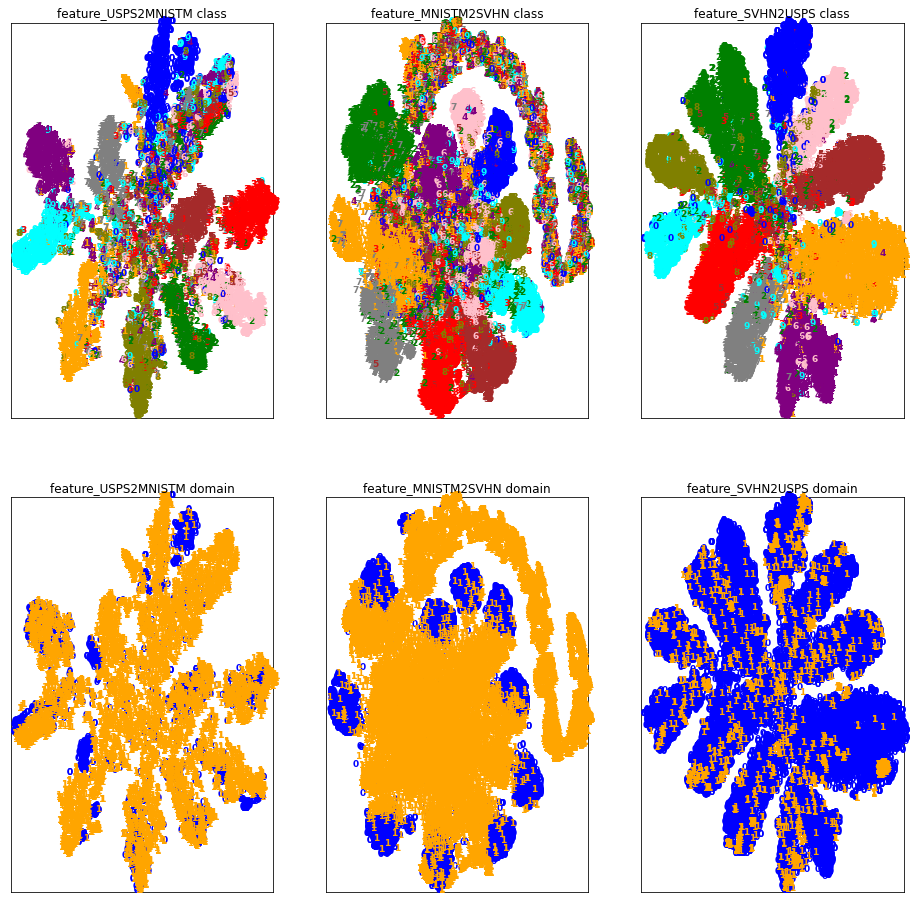

In [ ]:
plt.figure(figsize=(16, 16))
color_map = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(6):
    plt.subplot(2, 3, i+1)
    if i%3 == 0: # USPS2MNISTM
        X_tsne = feature_USPS2MNISTM_embedded
        if i == 0: # num
            y = class_USPS2MNISTM
            plt.title('feature_USPS2MNISTM class')
        else: # domain
            y = domain_USPS2MNISTM
            plt.title('feature_USPS2MNISTM domain')

    elif i%3 == 1: # USPS2MNISTM
        X_tsne = feature_MNISTM2SVHN_embedded
        if i == 1: # num
            y = class_MNISTM2SVHN
            plt.title('feature_MNISTM2SVHN class')
        else: # domain
            y = domain_MNISTM2SVHN
            plt.title('feature_MNISTM2SVHN domain')
    else: # i == 2 or i == 5 SVHN2USPS     
        X_tsne = feature_SVHN2USPS_embedded
        if i == 2: # num
            y = class_SVHN2USPS
            plt.title('feature_SVHN2USPS class')
        else: #  domain 
            y = domain_SVHN2USPS
            plt.title('feature_SVHN2USPS domain')
    print('ok')      

    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  # normalize
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=color_map[y[i]], fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])

plt.savefig(os.path.join(path, 'p3_tsne_feature.jpg'))
print('save tsne image')
plt.show()

5. Describe the architecture & implementation detail of your model. (6%)

6. Discuss what you’ve observed and learned from implementing DANN. (7%)